In [7]:
import itertools 
import matplotlib.pyplot as pyplot
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D
import robotdatapy
import datetime as dt 
from robotdatapy.data import ImgData, PoseData
from robotdatapy.transform import T_FLURDF
import pandas as pd 
from scipy.spatial.transform import Rotation as Rot 

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image
import pandas as pd 


import inspect 

In [4]:
### Extract data

# Data params 
time_tol = 0.5

# path_img = '../kimera_dataset/thoth'
# path_pose = '../kimera_dataset/thoth_vio' 

# depth_topic = '/thoth/forward/depth/image_rect_raw'
# rgb_topic = '/thoth/forward/color/image_raw/compressed'
# pose_topic = '/thoth/kimera_vio_ros/odometry'
# depth_info_topic = '/thoth/forward/depth/camera_info'
# rgb_info_topic = '/thoth/forward/color/camera_info'


# File paths 
# pose_bag = '/home/jrached/cv_project_code/highbay_dataset/test1/odometry'
path_img = '/home/jrached/cv_project_code/highbay_dataset/test1/cv_bag2' 

# Topics 
quad_pose_topic = '/BD01/world'
scout_pose_topic = '/SCOUT2/world'
dog_pose_topic = '/RAVAGE/world'
depth_topic = '/camera/camera/depth/image_rect_raw'
rgb_topic = '/camera/camera/color/image_raw'
depth_info_topic = '/camera/camera/color/camera_info'
rgb_info_topic = '/camera/camera/color/camera_info'


# pose_data = PoseData.from_bag(
#     path=path_pose, 
#     topic=pose_topic, 
#     time_tol=time_tol
# )
# rgb_data = ImgData.from_bag(
#     path=path_img, 
#     topic=rgb_topic, 
#     camera_info_topic=rgb_info_topic,
#     time_tol=time_tol, 
#     compressed=True
# )
depth_data = ImgData.from_bag(
    path=path_img, 
    topic=depth_topic, 
    camera_info_topic=depth_info_topic,
    time_tol=time_tol, 
    compressed=False
)


In [16]:
# Get poses 

# poses = [pose_data._untransformed_position(time) for time in pose_data.times]

# print(poses[1750:])

# pose_times = pose_data.times
# pose_data.pose(pose_data.t0)
# print(f"Size of depth data: {len(depth_data.times)}")
# print(f"Size of rgb data: {len(rgb_data.times)}")
# print(f"Size of pose data: {len(pose_data.times)}")

# print(f"Depth times: {depth_data.times}")
# print(f"RGB times: {rgb_data.times}")
print(f"Depth intrinsics: {depth_data.K}")
intrinsics_df = pd.DataFrame(depth_data.K.reshape(-1, 1))
intrinsics_df.to_csv("/home/jrached/cv_project_code/project/data/highbay1/intrinsics/depth_intrinsics.csv", index=False)
depth_data.img(depth_data.times[1]).shape

Depth intrinsics: [[425.84716797   0.         430.95541382]
 [  0.         425.39099121 239.37269592]
 [  0.           0.           1.        ]]


(480, 848)

(480, 640)

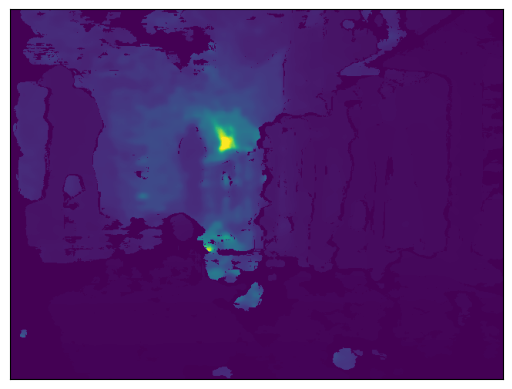

In [4]:
## Get depth 

# inspect.getmembers(depth_data)
depth_times = depth_data.times
depth_data.show(depth_times[1750])

depth_data.img(depth_data.t0).shape



16562

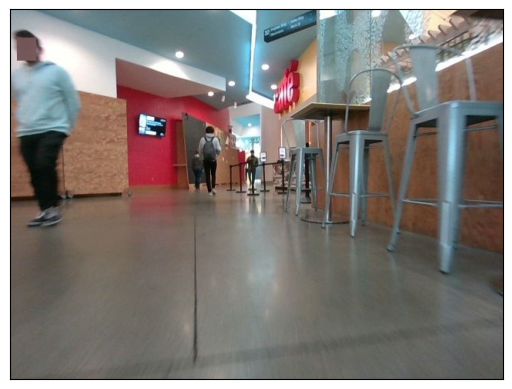

In [5]:
### Show data
rgb_times = rgb_data.times 
rgb_data.show(rgb_times[1750])

rgb_data.img(rgb_times[0])[:,:,0]
len(rgb_times)



In [6]:
# Intrinsics
print(f"Depth intrinsics:\n {depth_data.K}\n")
print(f"RGB intrinsics:\n {rgb_data.K}\n")

Depth intrinsics:
 [[386.88305664   0.         312.75875854]
 [  0.         386.88305664 237.32907104]
 [  0.           0.           1.        ]]

RGB intrinsics:
 [[380.80969238   0.         315.84698486]
 [  0.         380.53787231 238.04495239]
 [  0.           0.           1.        ]]



In [7]:
def flow_to_rgb(flow, max_magnitude=None):
    """Convert optical flow to RGB image (like RAFT visualization)."""
    h, w, _ = flow.shape
    hsv = np.zeros((h, w, 3), dtype=np.float32)

    # Compute magnitude and angle
    fx, fy = flow[..., 0], flow[..., 1]
    magnitude, angle = cv2.cartToPolar(fx, fy, angleInDegrees=True)

    # Normalize hue to [0, 180] for OpenCV HSV
    hsv[..., 0] = angle / 2.0

    # Normalize magnitude to [0, 1]
    if max_magnitude is None:
        max_magnitude = np.max(magnitude)
    if max_magnitude > 0:
        hsv[..., 1] = magnitude / max_magnitude
    else:
        hsv[..., 1] = 0

    hsv[..., 2] = 1.0  # Full brightness

    # Convert HSV to RGB (note: OpenCV uses BGR by default)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return (rgb * 255).astype(np.uint8)

def viz_video(img, flo, fps):
    # map flow to rgb image
    flo = flow_to_rgb(flo)
    img_flo = np.concatenate([img, flo[:, :, [2, 1, 0]]], axis=0)

    cv2.imshow('image', img_flo/255.0)
    
    # Wait for fps 
    key = cv2.waitKey(int(1000 / fps)) & 0xFF 
    # key = cv2.waitKey(1) & 0xFF 

    # Break if q is pressed or video finished
    if key == ord('q'):
        return False
    
    return True

class Frame():
    def __init__(self, image, depth, pose, intrinsics):
        """
        Class attributes: 
            - image, nd.array of shape (h, w, 3)
            - depth, nd.array of shape (h, w)
            - extrinsics, nd.array of shape (4, 4)
            - intrinsics, nd.array of shape (3, 3)
        """
        self.image = image
        self.depth = depth
        self.extrinsics = pose
        self.intrinsics = intrinsics


def scene_flow(frames):
    """
    Computes the scene flow giving a video as a list of frame objects. 
    Each object contains the extrinsics, intrinsics, depth, and image for 
    that frame. 

    inputs: 
        - frames, a video represented as a list of frame objects. 
    outputs: 
        - The scene flow for each frame.
    """

    prev_frame = frames[0]
    frame_flow = []
    for frame in frames[1:]:
        # Create grid, flatten it in raster order, and homogenize it
        h, w, c = prev_frame.image.shape 
        # pixel_coords_c1 = np.mgrid[:w, :h].reshape(h*w, 2) #TODO: Double check shape
        xs, ys = np.meshgrid(np.arange(w), np.arange(h))
        pixel_coords_c1 = np.stack((xs, ys), axis=-1).reshape(-1, 2)
        pixel_coords_c1 = np.hstack((pixel_coords_c1, np.ones((h*w, 1))))

        # Unproject: X_c1 = Z * K**-1 @ x_pix1 
        intrinsics = prev_frame.intrinsics 
        depth = prev_frame.depth[pixel_coords_c1[:, 1].astype(int), pixel_coords_c1[:, 0].astype(int)]
        points_c1f = depth.reshape(h*w, 1) * (np.linalg.inv(intrinsics) @ pixel_coords_c1.T).T
        points_c1f = np.hstack((points_c1f, np.ones((h*w, 1))))         

        # Transform to world frame 
        extrinsics = prev_frame.extrinsics 
        points_wf = (extrinsics @ points_c1f.T).T 

        # Transform to cam2 frame 
        extrinsics = frame.extrinsics
        points_c2f = (extrinsics @ points_wf.T).T[:, :-1] 

        # Project 3d points to cam2 image 
        intrinsics = frame.intrinsics 
        pixel_coords_c2 = (intrinsics @ points_c2f.T).T 
        pixel_coords_c2 = pixel_coords_c2 / pixel_coords_c2[:, 2:3]

        # Compute flow 
        flow = (pixel_coords_c2[:, :-1] - pixel_coords_c1[:, :-1]).reshape(h, w, 2)
        frame_flow.append(flow)
    
    return frame_flow

def scene_flow_gen(intrinsics, depth_generator):
    """
    Computes the scene flow giving a video as a list of frame objects. 
    Each object contains the extrinsics, intrinsics, depth, and image for 
    that frame. 

    inputs: 
        - frames, a video represented as a list of frame objects. 
    outputs: 
        - The scene flow for each frame.
    """

    for depth, extrinsics in depth_generator():
        prev_depth = depth 
        prev_extrinsics = extrinsics
        break 

    frame_flow = []
    for depth, extrinsics in depth_generator():
        # Create grid, flatten it in raster order, and homogenize it
        h, w = prev_depth.shape 
        # pixel_coords_c1 = np.mgrid[:w, :h].reshape(h*w, 2) #TODO: Double check shape
        xs, ys = np.meshgrid(np.arange(w), np.arange(h))
        pixel_coords_c1 = np.stack((xs, ys), axis=-1).reshape(-1, 2)
        pixel_coords_c1 = np.hstack((pixel_coords_c1, np.ones((h*w, 1))))

        # Unproject: X_c1 = Z * K**-1 @ x_pix1 
        # intrinsics = prev_frame.intrinsics 
        prev_depth = prev_depth[pixel_coords_c1[:, 1].astype(int), pixel_coords_c1[:, 0].astype(int)]
        points_c1f = prev_depth.reshape(h*w, 1) * (np.linalg.inv(intrinsics) @ pixel_coords_c1.T).T
        points_c1f = np.hstack((points_c1f, np.ones((h*w, 1))))         

        # Transform to world frame 
        # extrinsics = prev_frame.extrinsics 
        points_wf = (prev_extrinsics @ points_c1f.T).T 

        # Transform to cam2 frame 
        # extrinsics = frame.extrinsics
        points_c2f = (extrinsics @ points_wf.T).T[:, :-1] 

        # Project 3d points to cam2 image 
        # intrinsics = frame.intrinsics 
        pixel_coords_c2 = (intrinsics @ points_c2f.T).T 
        pixel_coords_c2 = pixel_coords_c2 / pixel_coords_c2[:, 2:3]

        # Compute flow 
        flow = (pixel_coords_c2[:, :-1] - pixel_coords_c1[:, :-1]).reshape(h, w, 2)
        frame_flow.append(flow)

        #Update past vars
        prev_depth = depth 
        prev_extrinsics = extrinsics
    
    return frame_flow




In [ ]:
# del flow_frames
# import gc 
# gc.collect()

In [8]:
import numpy as np 
from scipy.spatial.transform import Rotation 
from scipy.spatial.transform import Slerp 

def interpolate_poses(pose_matrices, source_times, target_times):
    """
    Interpolate poses to match target timestamps. 

    Inputs: 
        - pose_matrices (list of np.ndarray): (N, 4, 4) poses
        - source_times (np.ndarray): (N,) timestamps for each pose
        - target_times (np.ndarray): (M,) timestamps for images
    Outputs: 
        - interpolated_poses (list of np.ndarray): (M, 4, 4) interpolated poses
    """

    pose_matrices = np.stack(pose_matrices) # Make (N, 4, 4)
    Rs = pose_matrices[:, 0:3, 0:3]
    ts = pose_matrices[:, 0:3, -1]

    # Convert rotation matrix to scipy rotation object 
    rot = Rotation.from_matrix(Rs)

    # Fix last source time for interpolation to fit 
    source_times[-1] = target_times[-1]

    # Interpolate rotation 
    slerp = Slerp(source_times, rot)
    inter_rots = slerp(target_times) 
    interp_Rs = inter_rots.as_matrix() 

    # Interpolate translation linearly 
    interp_ts = np.array([np.interp(target_times, source_times, ts[:, i]) for i in range(3)]).T

    # Put poses matrix back together 
    # print(f"Shape of interp_R: {interp_Rs.shape}")
    interpolated_poses = []
    for R_i, t_i in zip(interp_Rs, interp_ts): 
        # R_i, t_i = interp_Rs[i], interp_ts[i]
        T = np.eye(4) 
        T[:3, :3] = R_i
        T[:3, 3] = t_i 
        interpolated_poses.append(T) 

    return interpolated_poses 

depth_times += -depth_times[0]
pose_times += -pose_times[0]

poses = [pose_data.pose(pose_times[i]) for i in range(len(pose_times))]
interpolated_poses = interpolate_poses(poses, pose_times, depth_times)


In [9]:
intrinsics = depth_data.K 

def depth_generator():
    start = 1000
    size = 500 
    for i in range(len(depth_times[start:start+size])):
        yield depth_data.img(depth_times[i]), interpolated_poses[i]

In [10]:
flow_frames = scene_flow_gen(intrinsics, depth_generator)

/tmp/ipykernel_1326493/569385496.py:149: RuntimeWarning: invalid value encountered in divide
  pixel_coords_c2 = pixel_coords_c2 / pixel_coords_c2[:, 2:3]


In [ ]:
def flow_generator():
    for i in range(1000): 
        yield rgb_data.img(rgb_times[i + 1000]), flow_frames[i]

for frame, flow_frame in flow_generator(): 
    viz_video(frame, flow_frame, 30)

/tmp/ipykernel_1326493/569385496.py:25: RuntimeWarning: invalid value encountered in cast
  return (rgb * 255).astype(np.uint8)


IndexError: list index out of range

: 